In [1]:
import os
import re
import sys
from typing import List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Flatten, Dense, Dropout, LSTM, MaxPool1D
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# List all files

DATA_PATH: str = os.path.join(os.getcwd(), 'Training_data')
data_files: List[str] = [os.path.join(DATA_PATH, file) for file in os.listdir(DATA_PATH) if re.match(r'.+TYPE[0-9]{2}.mat', file)]
    
data_files: List[str] = sorted(data_files)

In [3]:
# load_data returns PPG signal data and its corresponding Heart Rate

def load_data(files: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    x = np.empty(shape=(0, 1000), dtype=np.float64)
    y = np.empty(shape=(0, 1), dtype=np.float64)

    for file in files:
        tmp = np.empty(shape=(0, 1000), dtype=np.float64)
        
        data = scipy.io.loadmat(file)['sig'][2,:]
        bpm = scipy.io.loadmat(file[:-4]+"_BPMtrace.mat")['BPM0']
        counter = 0
        
        for i in range(1000, len(data), 250):
            tmp = np.concatenate((tmp, data[i-1000:i].reshape(1, -1)))
            y = np.concatenate((y, bpm[counter].reshape(-1, 1)))
                        
            counter += 1
                
        tmp = StandardScaler().fit_transform(tmp.reshape(tmp.shape[0], tmp.shape[1]))
        x = np.concatenate((x, tmp))
        
        print("{}: x:{}, y:{}".format(os.path.basename(os.path.normpath(file)), x.shape, y.shape))
    
    return x, y

In [4]:
x, y = load_data(data_files)

DATA_01_TYPE01.mat: x:(148, 1000), y:(148, 1)
DATA_02_TYPE02.mat: x:(296, 1000), y:(296, 1)
DATA_03_TYPE02.mat: x:(436, 1000), y:(436, 1)
DATA_04_TYPE02.mat: x:(581, 1000), y:(581, 1)
DATA_05_TYPE02.mat: x:(727, 1000), y:(727, 1)
DATA_06_TYPE02.mat: x:(877, 1000), y:(877, 1)
DATA_07_TYPE02.mat: x:(1020, 1000), y:(1020, 1)
DATA_08_TYPE02.mat: x:(1180, 1000), y:(1180, 1)
DATA_09_TYPE02.mat: x:(1329, 1000), y:(1329, 1)
DATA_10_TYPE02.mat: x:(1478, 1000), y:(1478, 1)
DATA_11_TYPE02.mat: x:(1620, 1000), y:(1620, 1)
DATA_12_TYPE02.mat: x:(1766, 1000), y:(1766, 1)


In [5]:
# cornet return model

def cornet_model(input_shape: Tuple[int, int]):
    inputs = keras.Input(shape=input_shape)
    x = Conv1D(filters=32, kernel_size=40, activation='relu', name='CNN1')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = MaxPool1D(pool_size=4)(x)
    x = Dropout(0.1)(x)

    x = Conv1D(filters=32, kernel_size=40, activation='relu', name='CNN2')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = MaxPool1D(pool_size=4)(x)
    x = Dropout(0.1)(x)

    x = LSTM(128, activation='tanh', return_sequences=True, name='LSTM1')(x)
    x = LSTM(128, activation='tanh', name='LSTM2')(x)
    
    output1 = Dense(1, name='Dense1')(x)

    model = keras.Model(inputs=inputs, outputs=output1)
    
    return model

In [6]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.show()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1337)
print("x_train: {}, x_test: {}, y_train:{}, y_test:{}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train: (1589, 1000), x_test: (1589, 1), y_train:(177, 1000), y_test:(177, 1)


In [8]:
# expand to 3 dim
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

In [9]:
model = cornet_model(x_train[0].shape)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
CNN1 (Conv1D)                (None, 961, 32)           1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 961, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 961, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 240, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 240, 32)           0         
_________________________________________________________________
CNN2 (Conv1D)                (None, 201, 32)           40992 

In [10]:
model.compile(loss='mae', optimizer=keras.optimizers.RMSprop(), metrics=['mae'])
history = model.fit(x_train, y_train, batch_size=25, epochs=50, validation_split=0.2, shuffle=False)

Train on 1271 samples, validate on 318 samples
Epoch 1/50
1271/1271 [==============================] - 9s 7ms/sample - loss: 118.7921 - mae: 118.7921 - val_loss: 115.4281 - val_mae: 115.4281
Epoch 2/50
1271/1271 [==============================] - 1s 849us/sample - loss: 110.7121 - mae: 110.7121 - val_loss: 108.8662 - val_mae: 108.8662
Epoch 3/50
1271/1271 [==============================] - 1s 846us/sample - loss: 104.1651 - mae: 104.1651 - val_loss: 102.2927 - val_mae: 102.2926
Epoch 4/50
1271/1271 [==============================] - 1s 846us/sample - loss: 97.5743 - mae: 97.5743 - val_loss: 95.7113 - val_mae: 95.7113
Epoch 5/50
1271/1271 [==============================] - 1s 851us/sample - loss: 90.9948 - mae: 90.9948 - val_loss: 89.1323 - val_mae: 89.1323
Epoch 6/50
1271/1271 [==============================] - 1s 855us/sample - loss: 84.4158 - mae: 84.4158 - val_loss: 82.5534 - val_mae: 82.5534
Epoch 7/50
1271/1271 [==============================] - 1s 850us/sample - loss: 77.8369 - m

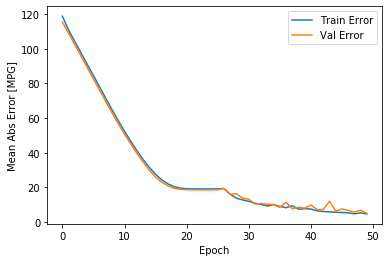

In [11]:
plot_history(history)

In [12]:
model.evaluate(x_test, y_test)

177/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[5.184732337455965, 5.1847324]